In [1]:
#carry out ML to extract urban areas. 
#can then extend this back in time to get when urban change took place.

In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

In [27]:
from __future__ import print_function, division
from osgeo import gdal, gdal_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_squared_error, classification_report
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image as ImageSave
from math import sqrt
import os
from IPython.display import Image

In [4]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [28]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.import_export import export_xarray_to_multiple_geotiffs


In [6]:
###Load in image
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_8"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (1)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2013-1-1'
baseline_end_date = '2019-12-30'
#nadi
aoi_wkt = "POLYGON((177.384445215936 -17.725841212511558,177.53619387316257 -17.725841212511558,177.53619387316257 -17.8278433805643,177.384445215936 -17.8278433805643,177.384445215936 -17.725841212511558))"

#suva
#aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

In [7]:
print(aoi_wkt)

POLYGON((177.384445215936 -17.725841212511558,177.53619387316257 -17.725841212511558,177.53619387316257 -17.8278433805643,177.384445215936 -17.8278433805643,177.384445215936 -17.725841212511558))


In [8]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3907860.7267941996, 3919261.380868996)
(1855235.5250584628, 1871249.8610571926)


In [10]:
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')
print(aoi)


                                               geoms
0  POLYGON ((177.38445 -17.72584, 177.53619 -17.7...


In [11]:
#import
import geopandas as gpd
df = gpd.read_file('urbanisation/footprint_Test_84.shp')
#df2 = df.filter(['geometry'])

In [12]:
#df2["geometry"] = df2["geometry"].astype("|S")
#print(df2)

In [13]:
#print(df2)

In [14]:
df['wkt'] = df.geometry.apply(lambda g: g.wkt)

In [15]:
#print(df)

In [16]:
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import pandas as pd

def create_lat_lon(test):
    #aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')
    aoi = test
    area_json = {
      "type": "FeatureCollection",
      "features": [
        {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "type": "Polygon",
            "coordinates": [
              [
                [
                    aoi.bounds.minx.values[0],
                    aoi.bounds.maxy.values[0]
                ],
                [
                    aoi.bounds.maxx.values[0],
                    aoi.bounds.maxy.values[0]
                ],
                [
                    aoi.bounds.maxx.values[0],
                    aoi.bounds.miny.values[0]
                ],
                [
                    aoi.bounds.minx.values[0],
                    aoi.bounds.miny.values[0]
                ],
                [
                    aoi.bounds.minx.values[0],
                    aoi.bounds.maxy.values[0]
                ]
              ]
            ]
          }
        }
      ]
    }

    lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
    lat_extents = (min(lats), max(lats))
    lon_extents = (min(lons), max(lons))
    return lat_extents, lon_extents

In [34]:
allmeasurements = ["nir","swir1"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_geomedian_annual'
        measurements = allmeasurements
        ###CHANGE WHEN S2 WOFS READY
        #water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements
        product = 'ls7_geomedian_annual'
        #water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements

In [35]:
baseline_product, measurement = create_product_measurement(platform_base)

In [36]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

In [37]:
#create resolution
resolution = (-res, res)

In [38]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [23]:
print(aoi_wkt)

POLYGON((177.384445215936 -17.725841212511558,177.53619387316257 -17.725841212511558,177.53619387316257 -17.8278433805643,177.384445215936 -17.8278433805643,177.384445215936 -17.725841212511558))


In [24]:
df3 = df.filter(['wkt'])
print(df3['wkt'])

0      POLYGON ((178.4434783 -18.14056899986548, 178....
1      POLYGON ((178.4433874 -18.14138009986547, 178....
2      POLYGON ((178.4460014 -18.14272809986547, 178....
3      POLYGON ((178.4456611 -18.14278669986546, 178....
4      POLYGON ((178.4453893 -18.14263799986547, 178....
                             ...                        
133    POLYGON ((178.4443724 -18.14025449986548, 178....
134    POLYGON ((178.4448694 -18.14041439986549, 178....
135    POLYGON ((178.4464721 -18.14089379986548, 178....
136    POLYGON ((178.4464543 -18.14076269986549, 178....
137    POLYGON ((178.446442 -18.14074419986548, 178.4...
Name: wkt, Length: 138, dtype: object


In [39]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks,
    'measurements': measurement
}


In [53]:
    from pyproj import Proj, transform
    inProj  = Proj("+init=EPSG:4326")
    outProj = Proj("+init=EPSG:3460")

In [54]:
 def NDBI(dataset):
        return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [81]:
product_data = []
n = 0
for index, rows in df3.iterrows():
    #print(rows)
    #print(rows.dtype)
    #a = gpd.GeoDataFrame(rows, geometry=rows)
    #print(rows['geometry'])
    #print(rows)
    a = rows['wkt']
    #print(POLYGON(a.geometry).wkt)
    ###need to export this geometry as a string!!! HOW!
    lat_extents, lon_extents = create_lat_lon(a)
    min_lat, max_lat = (lat_extents) 
    min_lon, max_lon = (lon_extents)
    x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
    x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
    lat_range = (y_A, y_B)
    lon_range = (x_A, x_B)
    baseline_ds = dc.load(
        time = baseline_time_period,
        product = baseline_product,
        platform = platform_base,
        crs = crs,
        **query
    )
    n = n + 1
    m = str(n)
    nameA = 'ndbi' 
    baseline_ds[nameA] = NDBI(baseline_ds)
    #print(baseline_ds)
    new = baseline_ds.drop(labels=['nir', 'swir1'])
    #print(new)
    #need to write a loop so doing this for each year, then looping that nad appending so end up
    'wiht a df for each year.'
    grid_mean = new.mean().rename({"ndbi": "ndbi_mean"})
    print(grid_mean)
    grid_mean = grid_mean.to_dataframe()
    #print(grid_mean)
    #test = baseline_ds['ndbi']
    #print(test)
    #product_data.append(new)

print(new)
print(new2)



<xarray.Dataset>
Dimensions:    ()
Data variables:
    ndbi_mean  float64 dask.array<chunksize=(), meta=np.ndarray>


ValueError: no valid index for a 0-dimensional object

In [ ]:
water_dataset = xr.concat(product_data, dim='time').sortby('time')

In [58]:
print(water_dataset)

<xarray.DataArray 'ndbi' (time: 966, y: 15, x: 19)>
dask.array<getitem, shape=(966, 15, 19), dtype=float64, chunksize=(1, 15, 19), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1.968e+06 1.968e+06 1.968e+06 ... 1.968e+06 1.968e+06
  * y        (y) float64 3.874e+06 3.874e+06 3.874e+06 ... 3.874e+06 3.874e+06
  * time     (time) datetime64[ns] 2013-07-02 2013-07-02 ... 2019-07-02


In [ ]:
def load_water_ds(products, t_bin, latitude, longitude, output_crs, measurements, scen):

    product_data = []
    for product in products:
        ds = dc.load(
            product=product,
            time=t_bin, 
            lat=latitude,
            lon=longitude,
            output_crs=output_crs,
            resolution=resolution,
            measurements = measurements,
            group_by='solar_day',
            dask_chunks={
                'time': 1,
                'x': 2202,            
                'y': 2416,
            }
        )
        if ds != None:
            if (scen == "WaterPersistence") | (scen == None):
                good_quality = (
                (ds.watermask >= 0) # no data
                )
            elif scen == "WaterPersistence95conf":                
                good_quality = (
                (ds.watermask >= 0) & # no data
                (
                    (ds.waterprob <= 5) |
                    (ds.waterprob >= 95)
                ) # predictions with >95% confidence
                )
            ds = ds.where(good_quality)
            product_data.append(ds)
    water_dataset = xr.concat(product_data, dim='time').sortby('time')
    print(f"EST GB: {water_dataset.nbytes/1000000000}\nDS: {water_dataset}")
    
    return water_dataset

('2019-01-01', '2019-12-31') 2019


In [19]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

AttributeError: 'str' object has no attribute 'bounds'

In [20]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [68]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3907860.7267941996, 3919261.380868996)
(1855235.5250584628, 1871249.8610571926)


In [172]:
allmeasurements = ["green","red", "blue", "nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_geomedian_annual'
        measurements = allmeasurements
        ###CHANGE WHEN S2 WOFS READY
        #water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements
        product = 'ls7_geomedian_annual'
        #water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements

In [173]:
baseline_product, measurement = create_product_measurement(platform_base)

In [174]:
#create resolution
resolution = (-res, res)

In [175]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [176]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

In [90]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': output_projection,
    'measurements': measurement,
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [91]:
baseline_ds = dc.load(
    time = baseline_time_period,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


In [92]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:  (time: 7, x: 1602, y: 1141)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02 2014-07-02 ... 2019-07-02
  * y        (y) float64 3.919e+06 3.919e+06 3.919e+06 ... 3.908e+06 3.908e+06
  * x        (x) float64 1.855e+06 1.855e+06 1.855e+06 ... 1.871e+06 1.871e+06
Data variables:
    green    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue     (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460


In [ ]:
img_ds = baseline_ds.compute()

In [181]:
#NDBI
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)
img_ds['ndbi'] = NDBI(img_ds)

In [182]:
#NDVI
from datacube_utilities.createindices import NDVI
img_ds['ndvi'] = NDVI(img_ds)

In [183]:
#MNDWI
def MNDWI(dataset):
    return (dataset.green - dataset.swir2)/(dataset.green + dataset.swir2)
img_ds['mndwi'] = MNDWI(img_ds)

In [184]:
#BU
img_ds['bu'] = img_ds['ndbi'] - img_ds['ndvi']

In [185]:
T1_img = img_ds.isel(time = 0)

In [186]:
#write_geotiff_from_xr('img_ds_S2_nadi.tiff', T1_img, crs=output_projection, x_coord = 'x', y_coord = 'y')

In [187]:
def export_slice_to_geotiff(ds, path, x_coord='longitude', y_coord='latitude'):
    """
    Exports a single slice of an xarray.Dataset as a GeoTIFF.
    ds: xarray.Dataset
        The Dataset to export. Must have exactly 2 dimensions - 'latitude' and 'longitude'.
    x_coord, y_coord: string
        Names of the x and y coordinates in `ds`.
    path: str
        The path to store the exported GeoTIFF.
    """
    kwargs = dict(tif_path=path, data=ds.astype(np.float64), bands=list(ds.data_vars.keys()),
                  x_coord=x_coord, y_coord=y_coord)
    if 'crs' in ds.attrs:
        kwargs['crs'] = str(ds.attrs['crs'])
    write_geotiff_from_xr(**kwargs)

In [188]:
export_slice_to_geotiff(T1_img, 'img_ds_s2_nadi_new.tif', x_coord = 'x', y_coord = 'y')

In [189]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [190]:
## vector to raster wtih same res as input raster

In [207]:
from osgeo import gdal
from osgeo import ogr
from osgeo import gdalconst

#dataset from which to base pixel size and extent for rasterization of training datasets
ndsm = 'img_ds_s2_suva_new.tif'
#training data
shp = 'attempt106.geojson'
#openlayers
data = gdal.Open(ndsm, gdalconst.GA_ReadOnly)
geo_transform = data.GetGeoTransform()
#source_layer = data.GetLayer()
#get dimensions
x_min = geo_transform[0]
y_max = geo_transform[3]
x_max = x_min + geo_transform[1] * data.RasterXSize
y_min = y_max + geo_transform[5] * data.RasterYSize
x_res = data.RasterXSize
y_res = data.RasterYSize
mb_v = ogr.Open(shp)
mb_l = mb_v.GetLayer()
pixel_width = geo_transform[1]
#name for output of rasterized geotif
output = 'my_s2.tif'

target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
proj=data.GetProjection() #y
target_ds.SetProjection(proj)
#target_ds.SetGeoTransform((x_min, pixel_width, 0, y_min, 0, pixel_width))
geotrans=data.GetGeoTransform()  #get GeoTranform from existed 'data0'

band = target_ds.GetRasterBand(1)
NoData_value = -999999
band.SetNoDataValue(NoData_value)
band.FlushCache()
target_ds.SetGeoTransform(geotrans)
gdal.RasterizeLayer(target_ds, [1], mb_l, options=["ATTRIBUTE=Class"])


target_ds = None

In [208]:
#path to image
#path to training/test data
#roi_ds = gdal.Open('testoutput.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('my_s2.tif', gdal.GA_ReadOnly)
img_ds = gdal.Open('img_ds_s2_suva_new.tif', gdal.GA_ReadOnly)

In [209]:
roi_dataset = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

In [210]:
print(roi_dataset.max())

5


roi = np.zeros((roi_ds.RasterYSize, roi_ds.RasterXSize, roi_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(roi_ds.GetRasterBand(1).DataType))
for b in range(roi.shape[2]):
    roi[:, :, b] = roi_ds.GetRasterBand(b + 1).ReadAsArray()
print(roi)

In [211]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    print(b)
#print(img)

0
1
2
3
4
5
6
7
8
9


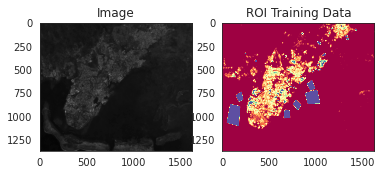

In [212]:
# Display the image and the Training/Test raster
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('Image')
plt.subplot(122)
plt.imshow(roi_dataset, cmap=plt.cm.Spectral, vmin=0, vmax=0.5)
plt.title('ROI Training Data')
plt.show()

In [213]:
labels = np.unique(roi_dataset[roi_dataset > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

The training data include 5 classes: [1 2 3 4 5]


In [214]:
#set X and y as image and training/test data.
X = img[roi_dataset > 0, :]
y = roi_dataset[roi_dataset > 0 ]

In [242]:
#Split the data into training and testing, by 80:20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

In [243]:
unique, counts = np.unique(y_train, return_counts=True)
dict_ytrain = dict(zip(unique, counts))
unique2, counts2 = np.unique(y_test, return_counts=True)
dict_ytest = dict(zip(unique2,counts2))
print("counts")
print('Train counts', counts)
print('Test counts', counts2)


counts
Train counts [31559   488   483 31420   583]
Test counts [21040   326   321 20947   389]


In [244]:
X_train2 = np.nan_to_num(X_train)
y_train2 = np.nan_to_num(y_train)

In [245]:
X_test2 = np.nan_to_num(X_test)
y_test2 = np.nan_to_num(y_test)

In [246]:
# Initialize random forest model with 200 trees, and balanced class weight
rf = RandomForestClassifier(n_estimators=200, oob_score=True, class_weight="balanced", min_samples_leaf=100)
rf = rf.fit(X_train2,y_train2)

In [247]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 95.8687803139479%


In [248]:
# Setup a dataframe, for truth and predicted values of training data
df = pd.DataFrame()
df['truth'] = y_train2
df['predict'] = rf.predict(X_train2)
# Setup a dataframe, for truth and predicted values of test data
df2 = pd.DataFrame()
df2['truth'] = y_test2
df2['predict'] = rf.predict(X_test2)

In [249]:
# Cross-tabulate predictions
print(pd.crosstab(df2['truth'], df2['predict'], margins=True))

predict      1    2    3      4     5    All
truth                                       
1        19405   26  374      9  1226  21040
2            1  323    0      0     2    326
3            6    1  281      0    33    321
4            7    0    0  20929    11  20947
5           12    7   52      0   318    389
All      19431  357  707  20938  1590  43023


In [250]:
#calculate kappa score
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict'])) *100
kappaScore = cohen_kappa_score(df2['truth'], df2['predict'])
kSPer = kappaScore*100
print("this is kappa", kSPer) 
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict']))


this is kappa 92.4175515095966


In [251]:
#calculate accuracy score
print('accuracy score', accuracy_score(df2['truth'], df2['predict']))
#print classification report
print(classification_report(df2['truth'], df2['predict']))

accuracy score 0.9589289449829161
              precision    recall  f1-score   support

           1       1.00      0.92      0.96     21040
           2       0.90      0.99      0.95       326
           3       0.40      0.88      0.55       321
           4       1.00      1.00      1.00     20947
           5       0.20      0.82      0.32       389

    accuracy                           0.96     43023
   macro avg       0.70      0.92      0.75     43023
weighted avg       0.99      0.96      0.97     43023



In [252]:
#This function prints and plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues, annot=True, annot_kws={"size": 3}):
    # Compute confusion matrix
    cm = confusion_matrix(df2['truth'], df2['predict'])
    # Only use the labels that appear in the data
    #classes = ('Built-up', 'Forest', 'Water', 'Grass', 'WB', 'WW', 'OSR')
    classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')
    print("diagonal", cm.diagonal()/cm.sum(axis=1))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    VALUE_SIZE = 10
    LABEL_SIZE = 12

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #show tick labels and label them with list enteries.
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize = LABEL_SIZE)
    plt.setp(ax.get_yticklabels(), fontsize = LABEL_SIZE)
    #path for output of normalised and non-normalised confusion matrices
    notn = 'cm.png'
    norm = 'ncm.png'

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=VALUE_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #save the outputs on the confusion matrices
    if normalize:
        plt.savefig(norm)
        print("saved to", norm)
    else:
        plt.savefig(notn)
        print("saved to", notn)
    return ax


diagonal [0.92 0.99 0.88 1.   0.82]
Confusion matrix, without normalization
[[19405    26   374     9  1226]
 [    1   323     0     0     2]
 [    6     1   281     0    33]
 [    7     0     0 20929    11]
 [   12     7    52     0   318]]
saved to cm.png
diagonal [0.92 0.99 0.88 1.   0.82]
Normalized confusion matrix
[[9.22e-01 1.24e-03 1.78e-02 4.28e-04 5.83e-02]
 [3.07e-03 9.91e-01 0.00e+00 0.00e+00 6.13e-03]
 [1.87e-02 3.12e-03 8.75e-01 0.00e+00 1.03e-01]
 [3.34e-04 0.00e+00 0.00e+00 9.99e-01 5.25e-04]
 [3.08e-02 1.80e-02 1.34e-01 0.00e+00 8.17e-01]]
saved to ncm.png


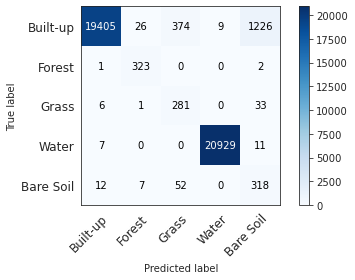

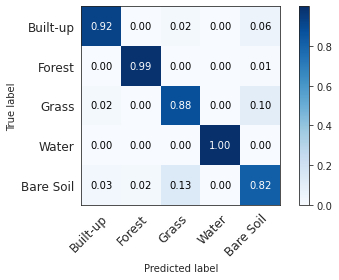

In [253]:
#class labels
classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes)

# Plot normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes, normalize=True)
plt.show()



In [254]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

In [255]:
img_as_array2 = np.nan_to_num(img_as_array)

In [256]:
# Now predict each pixel in the image.
class_prediction = rf.predict(img_as_array2)

In [257]:
# Reshape classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print(np.unique(class_prediction))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

[1 2 3 4 5]


In [258]:
print(class_prediction.shape)
xsize = class_prediction.shape[0]
ysize = class_prediction.shape[1]
print(xsize)

(1368, 1626)
1368


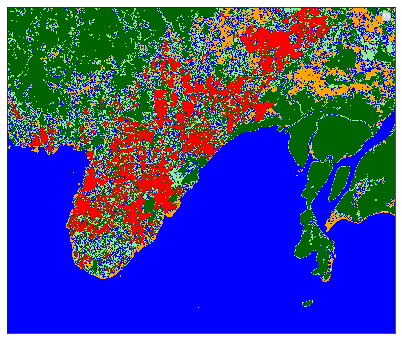

In [259]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction))
plt.show()

In [260]:
dst_filename = 'xxxS2_new.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename, x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction)

# follow code is adding GeoTranform and Projection
geotrans=img_ds.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

## Test on new area

In [261]:
#img_ds2 = gdal.Open('img_ds2.tiff', gdal.GA_ReadOnly)
img_ds2 = gdal.Open('img_ds_s2_nadi_new.tif', gdal.GA_ReadOnly)

In [262]:
img2 = np.zeros((img_ds2.RasterYSize, img_ds2.RasterXSize, img_ds2.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds2.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img2.shape[2]):
    img2[:, :, b] = img_ds2.GetRasterBand(b + 1).ReadAsArray()
    print(b)
#print(img2)

0
1
2
3
4
5
6
7
8
9


In [263]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape2 = (img2.shape[0] * img2.shape[1], img2.shape[2])
img_as_array2 = img2[:, :, :].reshape(new_shape2)

In [264]:
# Now predict each pixel in the image.
class_prediction2 = rf.predict(img_as_array2)

In [265]:
# Reshape classification map
class_prediction2 = class_prediction2.reshape(img2[:, :, 0].shape)
print(np.unique(class_prediction2))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

[1 2 3 4 5]


In [266]:
print(class_prediction2.shape)
xsize2 = class_prediction2.shape[0]
ysize2 = class_prediction2.shape[1]
print(xsize2)

(1141, 1602)
1141


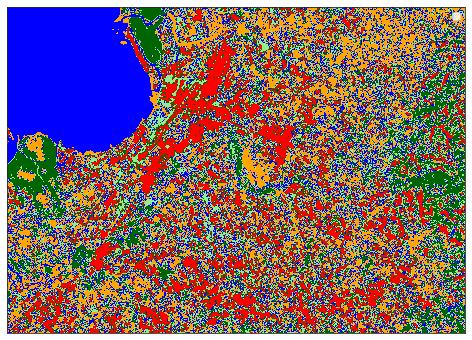

In [267]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction2, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction2))
plt.show()

In [268]:
dst_filename = 'xxx_s2_nadi_new.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction2)

# follow code is adding GeoTranform and Projection
geotrans=img_ds2.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds2.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None